# What deep learning sees while learning from complementary labels.

This notebook shows what the deep learning take attention if it is trained with complementary labels. In this context, the complementary labels mean wrong labels: "cat" image is labelled "dog" or "bird".<br>
It is possible to train a model using complementary labels, just by letting the deep learning to learn the training image is NOT the labelled class. So, it learns to get the wrong answers, corresponding to the complementary labels, and notices the image class is something that is not label as.<br>
https://arxiv.org/abs/1705.07541

The aim of the notebook is to show what the model sees after trained with the complementary labels. <br>
Since the model learns from the wrong classes, what are the features the model take attention on?<br>
Is it different from the model trained with the regular right labels?

In order to clarify what features are seen through the models, I used Grad-Cam to visualize what part in the image is extracted.<br>
https://arxiv.org/abs/1610.02391

## Preparation
I used a part of Caltech101 images for input dataset.<br>
In order to make the problem simple, I used only the "airplanes", "motorbike", "watch" and "Leopard" images.<br>
These classes are chosen for it contains enough amount of files, more than 200. Although  there are more than 700 images for the motorbike and the airplane, I sampled only 200 out of them, to get about the equal amount as wath and leopard images.<br>
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [2]:
import os
import requests
import tarfile
import sys
import numpy as np
import pandas as pd
from PIL import Image
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import random

### Download images

In [3]:
def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    return local_filename

In [4]:
def untar_file(file_path):
    with tarfile.open(file_path) as f:
        f.extractall()
        f.close()

In [5]:
def get_file_dict(directory):
    sub_dir = os.listdir(directory)
    files_dict = {}
    for s in sub_dir:
        files_dict[s] = [os.path.join(directory, os.path.join(s, f)) for f in os.listdir(os.path.join(directory, s))]
    return files_dict

In [6]:
pwd = os.getcwd()
caltech_dir = os.path.join(pwd,"101_ObjectCategories")
annot_dir = os.path.join(pwd, "Annotations")

In [7]:
if not os.path.exists(os.path.join(pwd, "101_ObjectCategories.tgz")):
    tar_img_file = download_file("http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz")
else:
    tar_img_file = "101_ObjectCategories.tgz"

if not os.path.exists(caltech_dir):
    untar_file(os.path.join(pwd, tar_img_file))

### A list of image classes and their amount of files

In [10]:
caltech_img_file_list = get_file_dict(caltech_dir)
for k,v in caltech_img_file_list.items():
    print(k, len(v))

BACKGROUND_Google 468
Faces 435
Faces_easy 435
Leopards 200
Motorbikes 798
accordion 55
airplanes 800
anchor 42
ant 42
barrel 47
bass 54
beaver 46
binocular 33
bonsai 128
brain 98
brontosaurus 43
buddha 85
butterfly 91
camera 50
cannon 43
car_side 123
ceiling_fan 47
cellphone 59
chair 62
chandelier 107
cougar_face 69
crab 73
crayfish 70
crocodile 50
crocodile_head 51
cup 57
dalmatian 67
dollar_bill 52
dolphin 65
dragonfly 68
electric_guitar 75
elephant 64
emu 53
euphonium 64
ewer 85
ferry 67
flamingo 67
flamingo_head 45
garfield 34
gerenuk 34
gramophone 51
grand_piano 99
hawksbill 100
headphone 42
hedgehog 54
helicopter 88
ibis 80
inline_skate 31
joshua_tree 64
kangaroo 86
ketch 114
lamp 61
laptop 81
llama 78
lobster 41
lotus 66
mandolin 43
mayfly 40
menorah 87
metronome 32
minaret 76
nautilus 55
octopus 35
okapi 39
pagoda 47
panda 38
pigeon 45
pizza 53
platypus 34
pyramid 57
revolver 82
rhino 59
rooster 49
saxophone 40
schooner 63
scissors 39
scorpion 84
sea_horse 57
snoopy 35
soccer_

### Preprocess imgages
Resizing images to 299 * 299 RGB and converting them to numpy array.

In [11]:
# get dict of label to image file list
caltech_dict = {0:["watch", caltech_img_file_list["watch"]], 
                1:["Leopards", caltech_img_file_list["Leopards"]], 
                2:["airplanes", random.sample(caltech_img_file_list["airplanes"], 200)], # choosing only 200 files from airplanes
                3:["Motorbikes", random.sample(caltech_img_file_list["Motorbikes"], 200)]} # choosing only 200 files from motorbikes

In [12]:
data_num = len(caltech_dict[0][1]) + len(caltech_dict[1][1]) + len(caltech_dict[2][1]) + len(caltech_dict[3][1])
for k,v in caltech_dict.items():
    print("{0}:\t{1} images".format(v[0], len(v[1])))
print("total:\t{0} images".format(data_num))

watch:	239 images
Leopards:	200 images
airplanes:	200 images
Motorbikes:	200 images
total:	839 images


In [13]:
def show_img(img):
  plt.imshow(img)
  plt.show()

0 watch
/opt/files/python/caltech/101_ObjectCategories/watch/image_0116.jpg


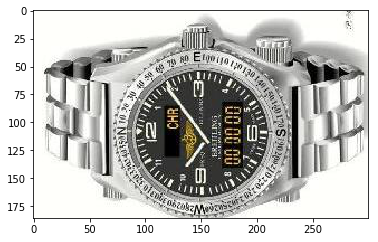

1 Leopards
/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0055.jpg


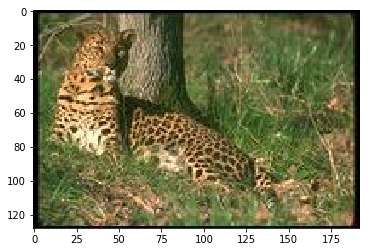

2 airplanes
/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0252.jpg


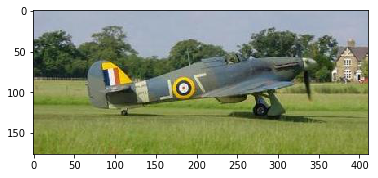

3 Motorbikes
/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0652.jpg


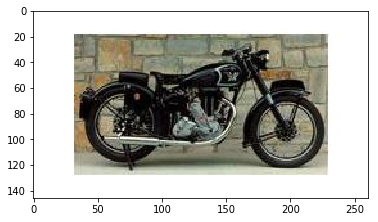

In [15]:
for k,v in caltech_dict.items():
  print(k,v[0])
  imgs = random.sample(v[1], 1)
  for i in imgs:
    print(i)
    img = Image.open(i)
    show_img(img)

In [16]:
# convert image files to numpy array
np_data = np.zeros((data_num,299,299,3))
np_labels = np.zeros((data_num, 1))
c = 0

for k,v in caltech_dict.items():
  print(k,v[0],len(v[1]))
  for l in v[1]:
    img = Image.open(l)
    if img.mode != "RGB":
      img = img.convert("RGB")
    np_img = np.asarray(img)
    np_img = transform.resize(np_img, (299,299))
    np_data[c] = np_img
    np_labels[c] = k
    c += 1
    
# save them
np.savez_compressed("dataset.npz", x=np_data)
np.savez_compressed("labels.npz", y=np_labels)

0 watch 239


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 Leopards 200
2 airplanes 200
3 Motorbikes 200


In [18]:
np_data=None
np_labels=None

## Define Xception model
Using Keras with Tensorflow backend and defining Xception model

In [19]:
import keras
from keras.utils import np_utils
from keras.models import Model

from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics

from sklearn.model_selection import train_test_split
import math

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load dataset

In [20]:
classes = 4

In [21]:
x = np.load("dataset.npz")["x"]
y = np.load("labels.npz")["y"]

# splitting 80% for training and 20% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                len(y_train), 
                                                                x_test.shape, 
                                                                len(y_test)))

x = None
y = None

x train:(671, 299, 299, 3)
y train:671
x test:(168, 299, 299, 3)
y test:168


In [22]:
# preprocess
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)
print(y_train.shape, y_test.shape)

(671, 4) (168, 4)


In [23]:
# the shape of image is (299,299,3) array
input_shape = (299,299,3)

In [24]:
# defining Xception
def Xception(input_shape=(299,299,3), classes=4):
    img_input = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x, name='xception')

    return model

### Train with regular labels
First train a model with regular, right class, labels. 

In [25]:
# model trained with regular labels
model = Xception()

In [26]:
# define optimization, using ADAM with learning rate of 0.00001 with decay and amsgrad
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=['accuracy'])

In [27]:
# early stopping
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

In [28]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True 
)

datagen.fit(x_train)

In [29]:
# train model
batch_size = 16
epochs = 1000

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, 
                    verbose=1,
                    shuffle=True,
                    callbacks=[es_cb])

Epoch 1/1000
41/41 [==============================] - 75s 2s/step - loss: 1.1006 - acc: 0.6153 - val_loss: 0.8130 - val_acc: 0.7321
Epoch 2/1000
41/41 [==============================] - 59s 1s/step - loss: 0.8103 - acc: 0.6993 - val_loss: 0.6118 - val_acc: 0.8214
Epoch 3/1000
41/41 [==============================] - 59s 1s/step - loss: 0.6571 - acc: 0.7449 - val_loss: 0.5137 - val_acc: 0.8095
Epoch 4/1000
41/41 [==============================] - 59s 1s/step - loss: 0.6028 - acc: 0.7754 - val_loss: 0.4155 - val_acc: 0.8452
Epoch 5/1000
41/41 [==============================] - 59s 1s/step - loss: 0.5046 - acc: 0.8138 - val_loss: 0.3554 - val_acc: 0.8869
Epoch 6/1000
41/41 [==============================] - 59s 1s/step - loss: 0.4479 - acc: 0.8474 - val_loss: 0.3844 - val_acc: 0.8452
Epoch 7/1000
41/41 [==============================] - 59s 1s/step - loss: 0.4233 - acc: 0.8442 - val_loss: 0.4564 - val_acc: 0.7917
Epoch 8/1000
41/41 [==============================] - 59s 1s/step - loss: 0.

In [30]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

168/168 [==============================] - 5s 29ms/step
[0.4021303057670593, 0.8809523809523809]


### Train a model with complementary labels

In [31]:
x = np.load("dataset.npz")["x"]
y = np.load("labels.npz")["y"]

# splitting 80% for training and 20% for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                len(y_train), 
                                                                x_test.shape, 
                                                                len(y_test)))

x = None
y = None

x train:(671, 299, 299, 3)
y train:671
x test:(168, 299, 299, 3)
y test:168


In [32]:
# generate complementary labels for training targets
# if the right label if 0, then the complementary label is either 1 or 2.

y_ctrain = np.zeros((len(y_train),1))
for i,v in enumerate(y_train):
    if v == 0:
        y_ctrain[i] = np.random.choice([1,2,3],1)
    elif v == 1:
        y_ctrain[i] = np.random.choice([0,2,3],1)
    elif v == 2:
        y_ctrain[i] = np.random.choice([0,1,3],1)
    elif v == 3:
        y_ctrain[i] = np.random.choice([0,1,2],1)

In [33]:
# generate complementary labels for test targets
# if the right label if 0, then the complementary label is either 1 or 2.

y_ctest = np.zeros((len(y_test), 1))
for i,v in enumerate(y_test):
    if v == 0:
        y_ctest[i] = np.random.choice([1,2,3],1)
    elif v == 1:
        y_ctest[i] = np.random.choice([0,2,3],1)
    elif v == 2:
        y_ctest[i] = np.random.choice([0,1,3],1)
    elif v == 3:
        y_ctrain[i] = np.random.choice([0,1,2],1)

In [34]:
# preprocess
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

y_ctrain = np_utils.to_categorical(y_ctrain, classes)
y_ctest = np_utils.to_categorical(y_ctest, classes)
y_train = np_utils.to_categorical(y_train, classes)
y_test = np_utils.to_categorical(y_test, classes)
print(y_ctrain.shape, y_ctest.shape)

(671, 4) (168, 4)


In [35]:
# defining sigmoid loss for complementary label training
def sigmoid_loss (target, output):
    return 1 / (1 + math.e ** K.categorical_crossentropy(target, output))

In [36]:
# defining pseudo accuracy for complementary label training
# this does not calculate right accuracy rate
def caccuracy (target, output):
    return 1 - metrics.categorical_accuracy(target, output)

In [37]:
# a model for complementary label
cmodel = Xception()

In [38]:
# define optimization, using ADAM with learning rate of 0.00001 with decay and amsgrad
opt = keras.optimizers.adam(lr=0.00001, decay=1e-6, amsgrad=True)
cmodel.compile(loss=sigmoid_loss,
               optimizer=opt,
               metrics=[caccuracy])

In [39]:
# data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True 
)

datagen.fit(x_train)

In [40]:
# train model
batch_size = 16
epochs = 1000

cmodel.fit_generator(datagen.flow(x_train, y_ctrain, batch_size=batch_size),
                     steps_per_epoch=x_train.shape[0] // batch_size,
                     validation_data=(x_test, y_ctest),
                     epochs=epochs, 
                     verbose=1,
                     shuffle=True,
                     callbacks=[es_cb])

Epoch 1/1000
41/41 [==============================] - 69s 2s/step - loss: 0.1880 - caccuracy: 0.8255 - val_loss: 0.1780 - val_caccuracy: 0.8452
Epoch 2/1000
41/41 [==============================] - 59s 1s/step - loss: 0.1344 - caccuracy: 0.8869 - val_loss: 0.1067 - val_caccuracy: 0.8631
Epoch 3/1000
41/41 [==============================] - 59s 1s/step - loss: 0.0968 - caccuracy: 0.8672 - val_loss: 0.0881 - val_caccuracy: 0.8750
Epoch 4/1000
41/41 [==============================] - 59s 1s/step - loss: 0.0818 - caccuracy: 0.8761 - val_loss: 0.0824 - val_caccuracy: 0.8571
Epoch 5/1000
41/41 [==============================] - 59s 1s/step - loss: 0.0774 - caccuracy: 0.8855 - val_loss: 0.0779 - val_caccuracy: 0.8690
Epoch 6/1000
41/41 [==============================] - 59s 1s/step - loss: 0.0729 - caccuracy: 0.8883 - val_loss: 0.0771 - val_caccuracy: 0.8631
Epoch 7/1000
41/41 [==============================] - 59s 1s/step - loss: 0.0727 - caccuracy: 0.8780 - val_loss: 0.0766 - val_caccuracy:

In [41]:
# calculating the right accuracy, compared to the right labels
cpred = cmodel.predict(x_test)

score = 0
for i in range(len(y_test)):
    if np.argmax(y_test[i]) == np.argmax(cpred[i]):
        score += 1
print(score / len(y_test))

0.6488095238095238


## Visualize Grad-Cam
Now that the models for regular label and complementary label are trained, let's visualize extracted features in the image using Grad-Cam.

In [42]:
import cv2

In [43]:
# convert image file to numpy array
def convert_img_to_np(img, size=(299,299)):
  img = Image.open(img)
  if img.mode != "RGB":
    img = img.convert("RGB")
  np_img = np.asarray(img)
  return transform.resize(np_img, size)

In [44]:
# convert numpy array to image
def convert_np_to_img(np_img):
  np_img *= 255
  return Image.fromarray(np.uint8(np_img))

In [45]:
# standardize pixels
def preprocess_img(np_img):  
  np_img = np.expand_dims(np_img, axis=0)

  np_img = np_img.astype('float32')
  return np_img / 255.0

In [46]:
# get model output for image
def get_model_output(model, np_img):
  label = np.argmax(model.predict(np_img)[0])
  print("label:\t{0}".format(label))
  return model.output[:, label]

In [47]:
# get conv function
def get_grad_func(model, layer, model_output):
  conv_output = model.get_layer(layer).output 
  grads = K.gradients(model_output, conv_output)[0] 
  return K.function([model.input], [conv_output, grads]) 

In [48]:
# get output from the function
def get_grads_val(gradient_function, np_img):
  output, grads_val = gradient_function([np_img])
  return output[0], grads_val[0]

In [49]:
# get grad cam
def get_grad_cam(output, grads_val, np_img, size=(299,299)):
  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)
  
  cam = cv2.resize(cam, size, cv2.INTER_LINEAR) 
  cam = np.maximum(cam, 0) 
  cam = cam / cam.max()
  
  gradcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
  gradcam = cv2.cvtColor(gradcam, cv2.COLOR_BGR2RGB)
  return (np.float32(gradcam) + np_img / 2)

In [50]:
# grad cam
def grad_cam(model, img, layer):
  np_img = convert_img_to_np(img)
  prep_np_img = preprocess_img(np_img)
  model_output = get_model_output(model, prep_np_img)    
  gradient_function = get_grad_func(model, layer, model_output)    
  output, grads_val = get_grads_val(gradient_function, prep_np_img)

  gradcam = get_grad_cam(output, grads_val, np_img)

  return gradcam

In [51]:
# show grad cam image
def show_gradcam(model, img, layer):
  gcam = grad_cam(model, img, layer)
  show_img(convert_np_to_img(gcam))

In [52]:
# show original and grad cam image
def show_img_and_gradcam(model, img, layer):
  show_img(convert_img_to_np(img))
  show_gradcam(model, img, layer)

###  visualize original image, grad cam with regular model and grad cam with complementary label model

/opt/files/python/caltech/101_ObjectCategories/watch/image_0004.jpg
ORIGINAL


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


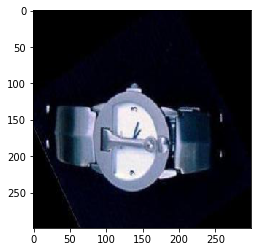

GRAD CAM REGULAR MODEL
label:	0


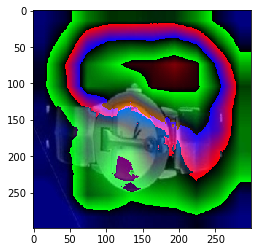

GRAD CAM COMPLEMENTARY MODEL
label:	3


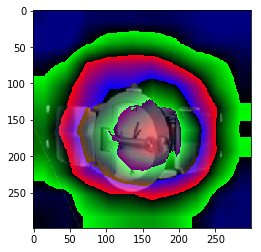

/opt/files/python/caltech/101_ObjectCategories/watch/image_0005.jpg
ORIGINAL


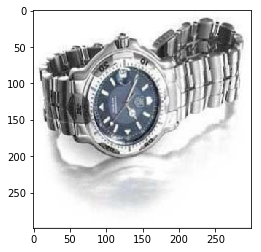

GRAD CAM REGULAR MODEL
label:	0


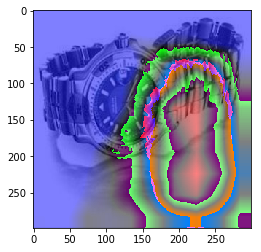

GRAD CAM COMPLEMENTARY MODEL
label:	3


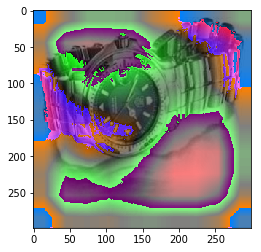

/opt/files/python/caltech/101_ObjectCategories/watch/image_0006.jpg
ORIGINAL


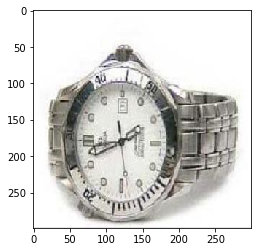

GRAD CAM REGULAR MODEL
label:	0


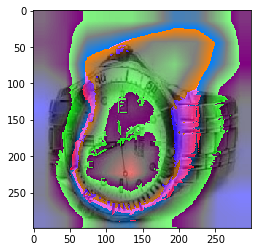

GRAD CAM COMPLEMENTARY MODEL
label:	3


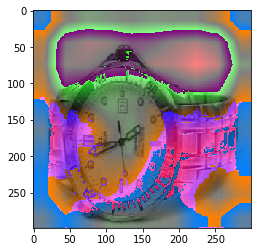

/opt/files/python/caltech/101_ObjectCategories/watch/image_0007.jpg
ORIGINAL


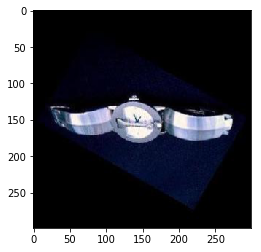

GRAD CAM REGULAR MODEL
label:	0


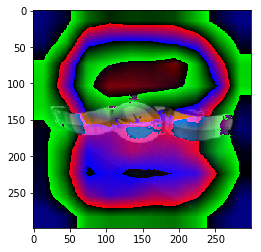

GRAD CAM COMPLEMENTARY MODEL
label:	3


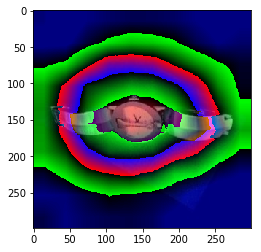

/opt/files/python/caltech/101_ObjectCategories/watch/image_0008.jpg
ORIGINAL


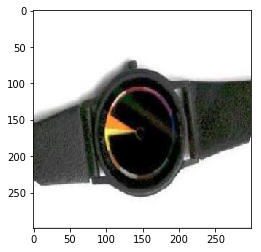

GRAD CAM REGULAR MODEL
label:	3


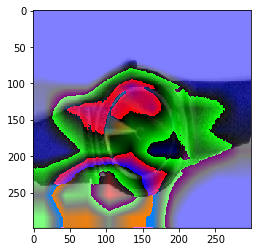

GRAD CAM COMPLEMENTARY MODEL
label:	3


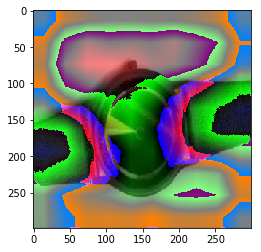

In [53]:
# WATCH
for j in range(5):
  img = caltech_dict[0][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")

/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0004.jpg
ORIGINAL


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


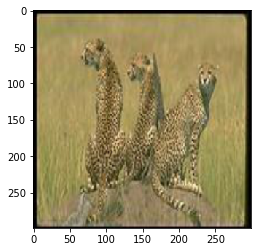

GRAD CAM REGULAR MODEL
label:	1


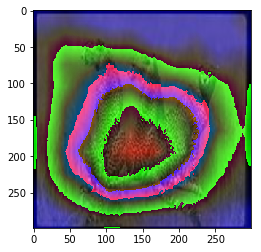

GRAD CAM COMPLEMENTARY MODEL
label:	2


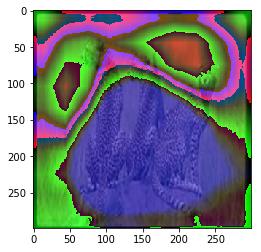

/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0005.jpg
ORIGINAL


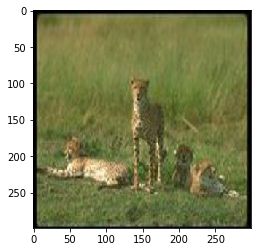

GRAD CAM REGULAR MODEL
label:	1


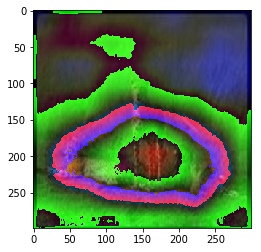

GRAD CAM COMPLEMENTARY MODEL
label:	1


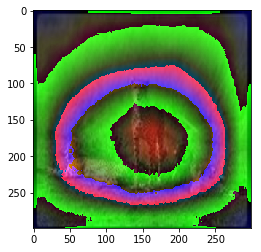

/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0006.jpg
ORIGINAL


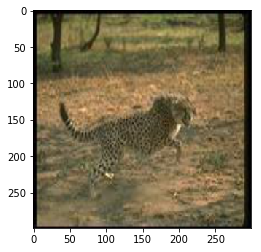

GRAD CAM REGULAR MODEL
label:	1


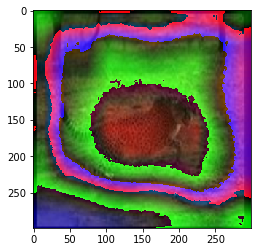

GRAD CAM COMPLEMENTARY MODEL
label:	1


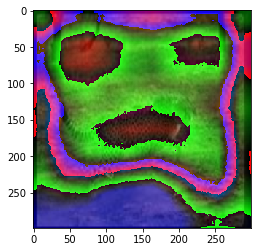

/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0007.jpg
ORIGINAL


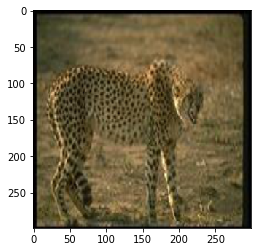

GRAD CAM REGULAR MODEL
label:	1


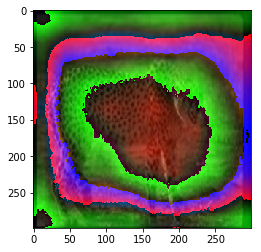

GRAD CAM COMPLEMENTARY MODEL
label:	1


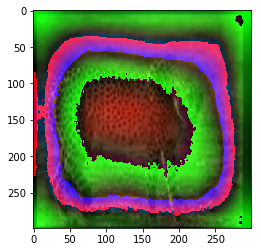

/opt/files/python/caltech/101_ObjectCategories/Leopards/image_0008.jpg
ORIGINAL


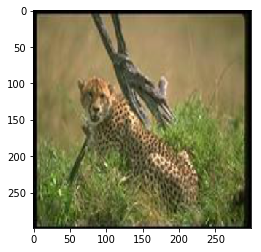

GRAD CAM REGULAR MODEL
label:	1


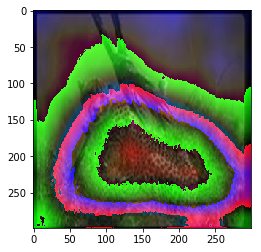

GRAD CAM COMPLEMENTARY MODEL
label:	1


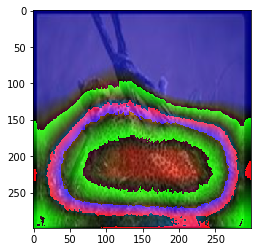

In [54]:
# LEOPARD
for j in range(5):
  img = caltech_dict[1][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")

/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0161.jpg
ORIGINAL


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


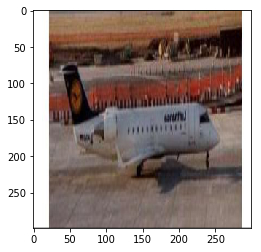

GRAD CAM REGULAR MODEL
label:	2


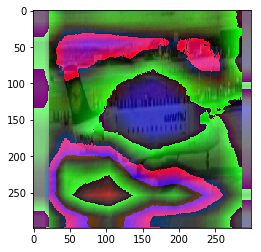

GRAD CAM COMPLEMENTARY MODEL
label:	2


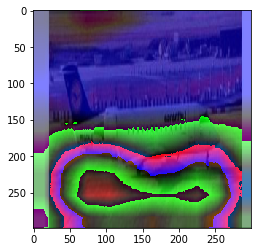

/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0479.jpg
ORIGINAL


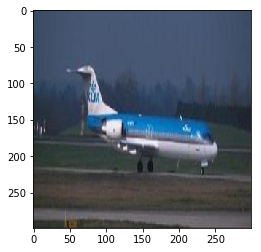

GRAD CAM REGULAR MODEL
label:	2


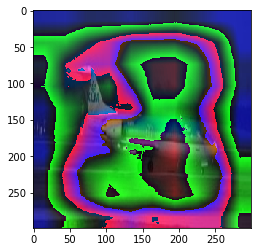

GRAD CAM COMPLEMENTARY MODEL
label:	2


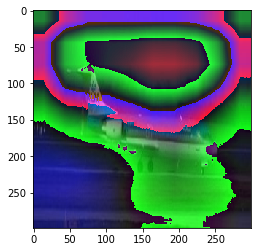

/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0778.jpg
ORIGINAL


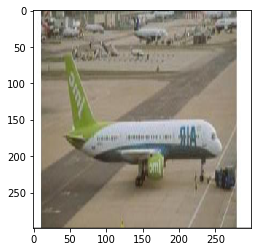

GRAD CAM REGULAR MODEL
label:	2


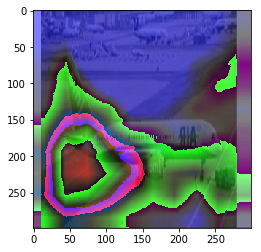

GRAD CAM COMPLEMENTARY MODEL
label:	2


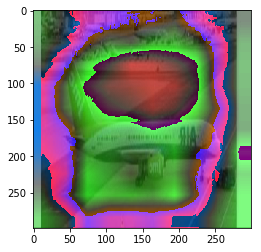

/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0461.jpg
ORIGINAL


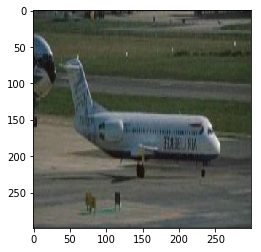

GRAD CAM REGULAR MODEL
label:	2


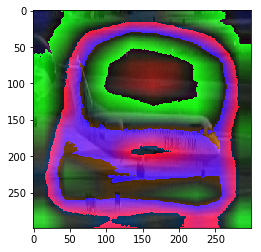

GRAD CAM COMPLEMENTARY MODEL
label:	2


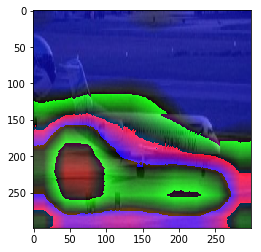

/opt/files/python/caltech/101_ObjectCategories/airplanes/image_0707.jpg
ORIGINAL


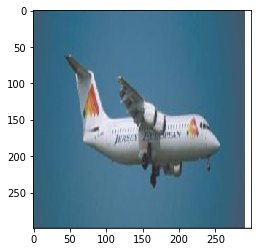

GRAD CAM REGULAR MODEL
label:	2


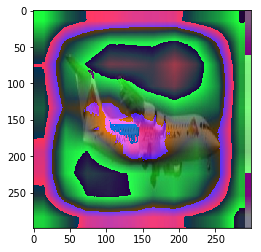

GRAD CAM COMPLEMENTARY MODEL
label:	2


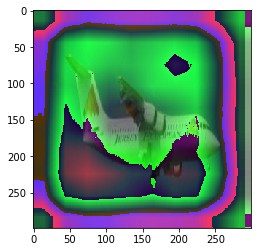

In [55]:
# AIRPLANE
for j in range(5):
  img = caltech_dict[2][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")

/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0222.jpg
ORIGINAL


/opt/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


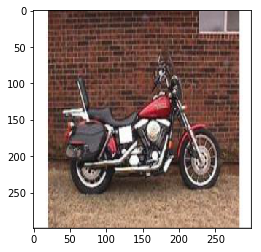

GRAD CAM REGULAR MODEL
label:	3


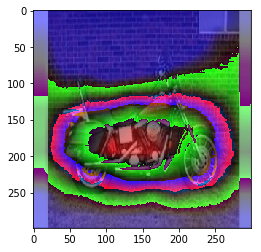

GRAD CAM COMPLEMENTARY MODEL
label:	3


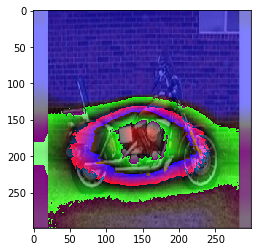

/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0731.jpg
ORIGINAL


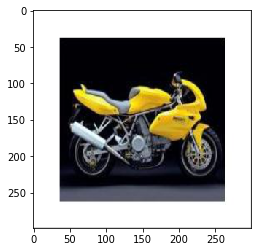

GRAD CAM REGULAR MODEL
label:	3


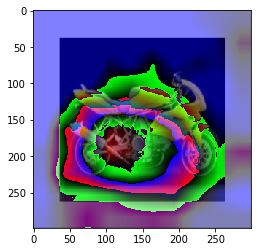

GRAD CAM COMPLEMENTARY MODEL
label:	3


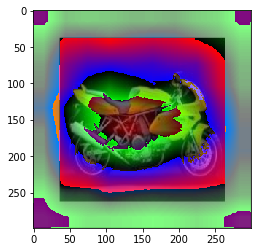

/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0675.jpg
ORIGINAL


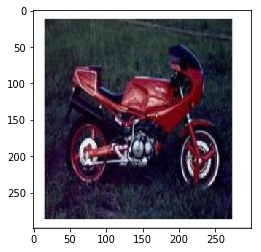

GRAD CAM REGULAR MODEL
label:	3


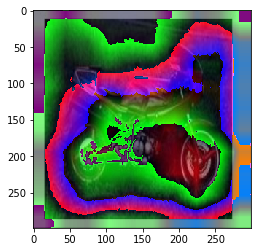

GRAD CAM COMPLEMENTARY MODEL
label:	3


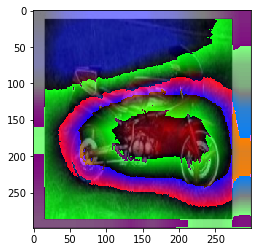

/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0277.jpg
ORIGINAL


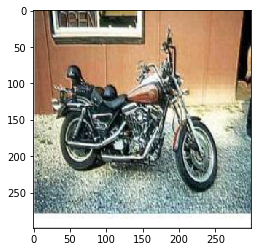

GRAD CAM REGULAR MODEL
label:	0


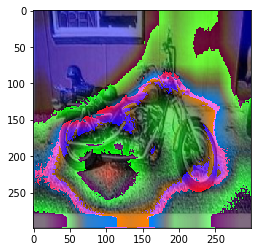

GRAD CAM COMPLEMENTARY MODEL
label:	3


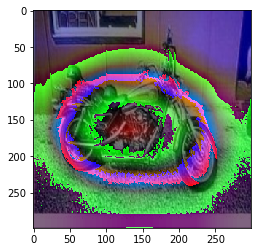

/opt/files/python/caltech/101_ObjectCategories/Motorbikes/image_0575.jpg
ORIGINAL


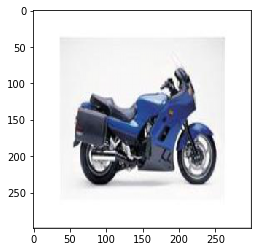

GRAD CAM REGULAR MODEL
label:	3


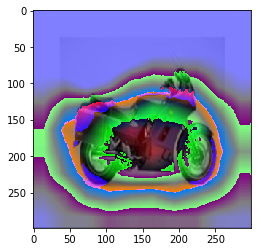

GRAD CAM COMPLEMENTARY MODEL
label:	3


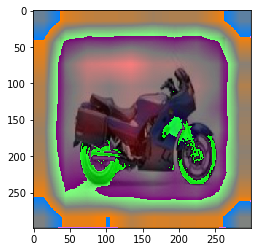

In [56]:
# MOTORBIKE
for j in range(5):
  img = caltech_dict[3][1][j]
  print(img)
  print("ORIGINAL")
  show_img(convert_img_to_np(img))
  print("GRAD CAM REGULAR MODEL")
  show_gradcam(model, img, "block14_sepconv2_act")
  print("GRAD CAM COMPLEMENTARY MODEL")
  show_gradcam(cmodel, img, "block14_sepconv2_act")